In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose, Flatten, Reshape
import numpy as np
from model.dcgan import generator_model, discriminator_model, DCGAN
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from utils.image_utils import preprocess_image, scaleback_image, image_loader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
import scipy
from utils.model_utils import make_latent_samples, generate_labels, make_trainable
from utils.visualizers_utils import show_generated_images, show_gan_losses

Number of images in the train set:  202599
shape of each image is : (218, 178, 3)
********************
Original Images
********************


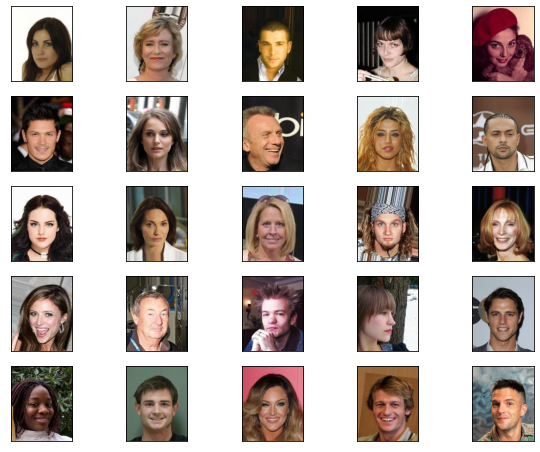

********************
After cropping & Reshaping
********************


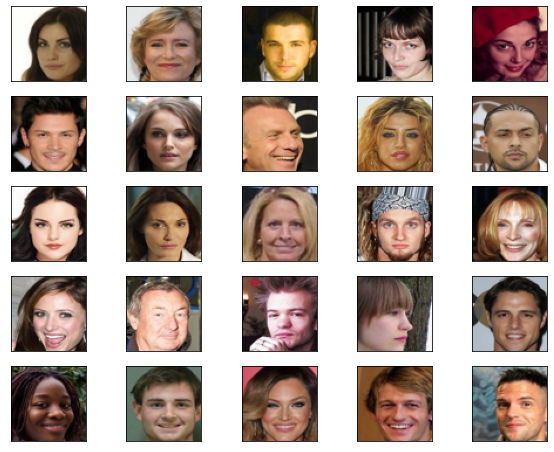

shape after cropping:  (64, 64, 3)


In [20]:
X_train = np.array(glob('data/celeba_dataset/img_align_celeba/*.jpg'))
print("Number of images in the train set: ", X_train.shape[0])
print("shape of each image is :", plt.imread(X_train[0]).shape)

print('*'*20)
print("Original Images")
print('*'*20)
plt.figure(figsize=(10, 8))
for i in range(25):
    image = plt.imread(X_train[i])
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

plt.show()

print('*'*20)
print("After cropping & Reshaping")
print('*'*20)

plt.figure(figsize=(10, 8))
for i in range(25):
    image = image_loader(X_train[i], resize_to=(64, 64))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
plt.show()
print("shape after cropping: ", image.shape)




In [29]:
def train(
    X_train, # training images files
    model_name, #model name for saving purposes
    generator_lr, # generator lr 
    generator_beta, # generator beta for adam
    discriminator_lr, # discriminator lr
    discriminator_beta, # discriminator beta
    alpha, # alpha for the Leaky ReLU layer
    normal_std, # normal distribution std
    epochs=5, # epochs
    batch_size=128,  # train batch size
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    show_results=True):

    # returns labels : real is set to 1, fake is set to 0
    y_train_real, y_train_fake = generate_labels(batch_size)

    #get the dcgan along with its generator and the discriminator
    dcgan, generator, discriminator = DCGAN(sample_size, normal_std, generator_lr, generator_beta, discriminator_lr, discriminator_beta, alpha)

    losses = []
    train_losses = [] 
    for epoch in range(epochs):
        d_train_loss = 0
        g_train_loss = 0
        for i in tqdm(range(len(X_train)//batch_size)):
            # real images from the dataset
#             print("ii isssss" , i)
            X_batch = X_train[i*batch_size:(i+1)*batch_size] #gets the file names 
            X_batch_real = np.array([preprocess_image(image_loader(file_)) for file_ in X_batch]) #get the images in the np format 


            latent_samples = make_latent_samples(batch_size, sample_size) # generate random numbers 
            X_batch_fake = generator.predict_on_batch(latent_samples) # get the output for random numbers

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)        

            # train the discriminator on real and fake images
            d_train_loss = discriminator.train_on_batch(X_batch_real, y_train_real)
            d_train_loss += discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via end to end learning
            make_trainable(discriminator, False)
            g_train_loss = dcgan.train_on_batch(latent_samples, y_train_real)
        losses.append((d_train_loss, g_train_loss))
        print('*'*40)
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            epoch+1, epochs, d_train_loss, g_train_loss))    
        print('*'*40)


    
    # show the result
        if show_results:
            show_generated_images(generator.predict(make_latent_samples(25, sample_size)), save_to=f'results/{model_name}/epochs_results/', epoch_no=epoch)    
    
    show_gan_losses(losses, save_to=f'results/{model_name}/final_results/')
    
    dcgan.save(f'trained_models/{model_name}/dcgan')
    generator.save(f'trained_models/{model_name}/generator')
    discriminator.save(f'trained_models/{model_name}/discriminator')
    return generator

In [ ]:
from tensorflow.keras.initializers import RandomNormal
train(X_train, 
      model_name='DCGAN_Celeba',
      epochs=10,
      generator_lr=0.0002, 
      generator_beta=0.5, 
      discriminator_lr=0.0002, 
      discriminator_beta=0.5, 
      alpha=0.2, 
      normal_std=0.02)


  1%|          | 12/1582 [00:14<28:50,  1.10s/it] 